In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

fn = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        fn.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/text-classification-documentation/df_file.csv


In [2]:
%%capture
!pip install catboost

In [3]:
# Data manipulation
#===========================================================================
import pandas as pd
import numpy as np

# Data visualization
#===========================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Preprocessing
#===========================================================================
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Models
#===========================================================================
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
#===========================================================================
from sklearn.metrics import confusion_matrix, accuracy_score

# tqdm
#===========================================================================
from tqdm.auto import tqdm

# warnings
#===========================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("/kaggle/input/text-classification-documentation/df_file.csv")
data.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [5]:
# Dataset size
#==================================
print(f'Rows: {data.shape[0]}')
print(f'Columns: {data.shape[1]}')

Rows: 2225
Columns: 2


In [6]:
print("--------------------------------------------")
print(" " * 10,"Dataset Information")
print("--------------------------------------------")
print(data.info())

--------------------------------------------
           Dataset Information
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB
None


In [7]:
print(data.duplicated().sum())

98


In [8]:
# Remove duplicate rows
#===========================================================
data = data.drop_duplicates(ignore_index = True)

print(data.duplicated().sum())

0


In [9]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100.
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values

,count,%
Text,0,0.0
Label,0,0.0


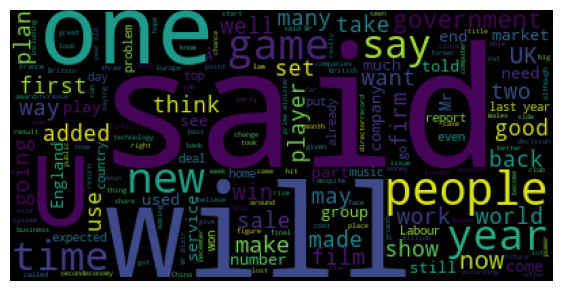

In [10]:
# WordCloud before preprocessing.
#===================================================================
all_text = " ".join(data['Text'])

wc = WordCloud(stopwords = STOPWORDS).generate(all_text)

plt.figure(figsize = (7,4))
plt.imshow(wc)
plt.axis('off')
plt.show()

-------------------------------------------------
Max Sequence before preprocessing: 4432
-------------------------------------------------


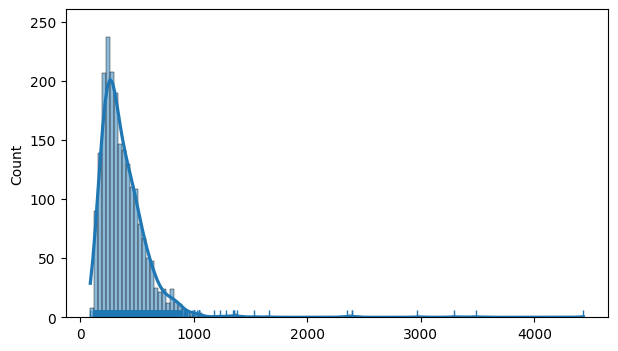

In [11]:
seq_len = []

for txt in data.Text:
    seq_len.append(len(txt.split()))
    
print('-------------------------------------------------')
print(f'Max Sequence before preprocessing: {max(seq_len)}')
print('-------------------------------------------------')
plt.figure(figsize = (7,4))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth': 2.3})
sns.rugplot(seq_len)
plt.show()

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def preprocess_text(txt:str):
    
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = txt.lower()
    txt = " ".join(txt.split())
    
    doc = nlp(txt)
    
    tokens_filtered = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
            
        tokens_filtered.append(token.lemma_)
        
    return " ".join(tokens_filtered)

In [14]:
data['prep_text'] = data['Text'].apply(preprocess_text)
data.head()

,Text,Label,prep_text
0,Budget to set scene for election\n \n Gordon B...,0,budget set scene election gordon brown seek ec...
1,Army chiefs in regiments decision\n \n Militar...,0,army chiefs regiment decision military chief e...
2,Howard denies split over ID cards\n \n Michael...,0,howard deny split d card michael howard deny s...
3,Observers to monitor UK election\n \n Minister...,0,observer monitor uk election minister invite i...
4,Kilroy names election seat target\n \n Ex-chat...,0,kilroy name election seat target ex chat host ...


-------------------------------------------------
Max Sequence after preprocessing: 2013
-------------------------------------------------


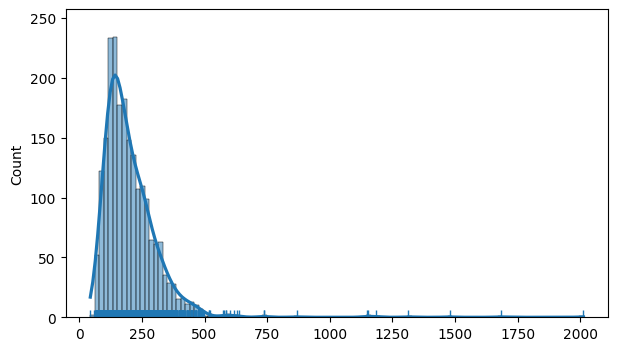

In [15]:
seq_len = []

for txt in data.prep_text:
    seq_len.append(len(txt.split()))
    
print('-------------------------------------------------')
print(f'Max Sequence after preprocessing: {max(seq_len)}')
print('-------------------------------------------------')
plt.figure(figsize = (7,4))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth': 2.3})
sns.rugplot(seq_len)
plt.show()

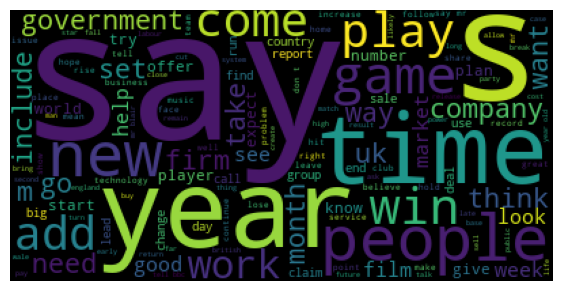

In [16]:
all_text = " ".join(data['prep_text'])

wc = WordCloud().generate(all_text)

plt.figure(figsize = (7,4))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [17]:
X = data['prep_text']
y = data['Label']

SEED = 123

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED, 
                                                    stratify = y)

print(f'X train total: {len(X_train)}')
print(f'X test total: {len(X_test)}')

X train total: 1488
X test total: 639


In [18]:
y_train.value_counts()

Label
1    353
4    352
0    282
3    258
2    243
Name: count, dtype: int64

In [19]:
# We transform our texts into numbers.
vectorizer = TfidfVectorizer()

features_train = vectorizer.fit_transform(X_train)
features_test = vectorizer.transform(X_test)

features_train = features_train.toarray()
features_test = features_test.toarray()

In [20]:
# We define the candidate models.
rf = RandomForestClassifier(random_state = SEED, n_jobs = -1)
et = ExtraTreesClassifier(bootstrap = True, n_jobs = -1, random_state = SEED)
xgb = XGBClassifier(random_state = SEED, n_jobs = -1)
lgbm = LGBMClassifier(random_state = SEED, n_jobs = -1)
cb = CatBoostClassifier(random_state = SEED, verbose = 0)

MODELS = [rf, et, xgb, lgbm, cb]

In [21]:
accuracy_train = {}
accuracy_test = {}

for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(features_train, y_train)
    y_pred_train = model.predict(features_train)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    y_pred_test = model.predict(features_test)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished')

  0%|          | 0/5 [00:00<?, ?it/s]

* RandomForestClassifier finished
* ExtraTreesClassifier finished
* XGBClassifier finished
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49496
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 1932
[LightGBM] [Info] Start training from score -1.663281
[LightGBM] [Info] Start training from score -1.438720
[LightGBM] [Info] Start training from score -1.812127
[LightGBM] [Info] Start training from score -1.752229
[LightGBM] [Info] Start training from score -1.441557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

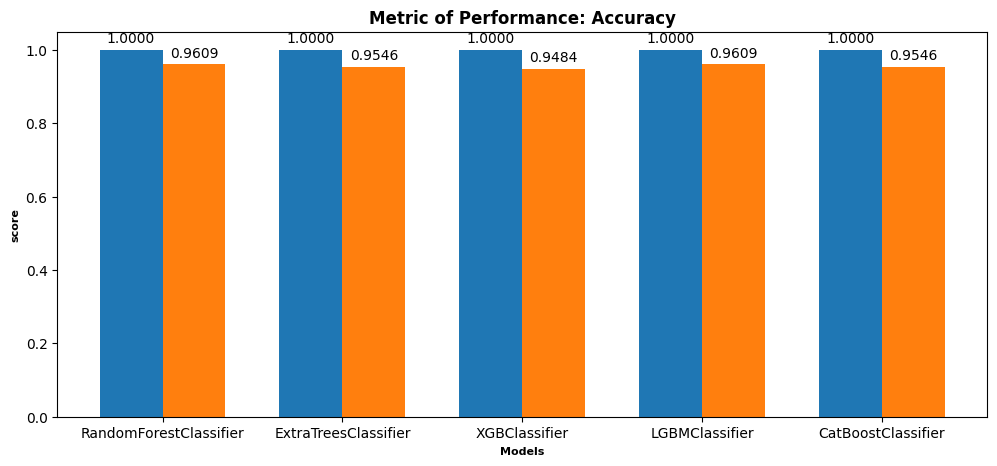

In [22]:
metric_train = pd.DataFrame.from_dict(accuracy_train, 
                                      orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, 
                                     orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (12,5))
plt.style.use('ggplot')

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width)
rects2 = ax.bar(x = x + width/2, height = values_test, width = width)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}', 
                    xy = (rect.get_x() + rect.get_width()/2, height), 
                    xytext = (0,3), 
                    textcoords = "offset points", 
                    ha = "center", 
                    va = "bottom")
        
autolabel(rects1)
autolabel(rects2)
ax.set_title("Metric of Performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49496
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 1932
[LightGBM] [Info] Start training from score -1.663281
[LightGBM] [Info] Start training from score -1.438720
[LightGBM] [Info] Start training from score -1.812127
[LightGBM] [Info] Start training from score -1.752229
[LightGBM] [Info] Start training from score -1.441557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


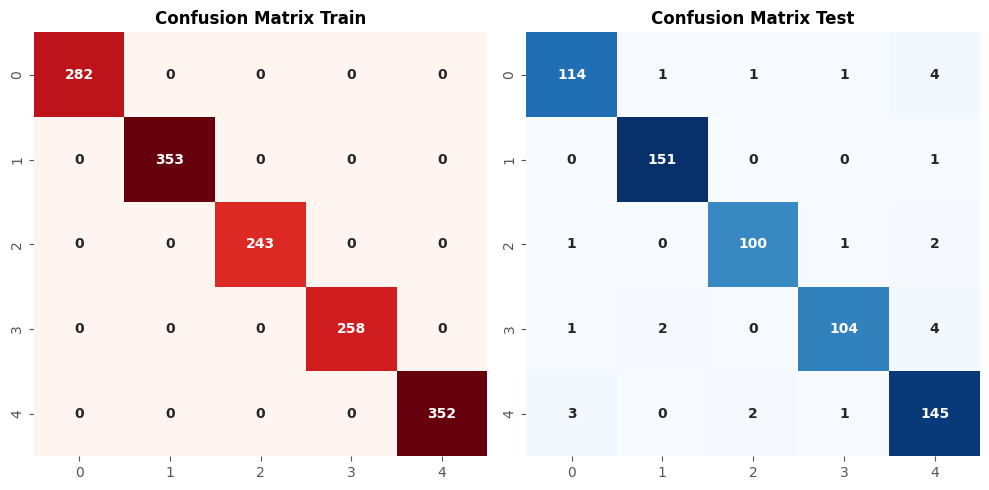

In [23]:
model = LGBMClassifier(random_state = SEED, n_jobs = -1)
model.fit(features_train, y_train)

y_pred_train = model.predict(features_train)
y_pred_test = model.predict(features_test)

cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

sns.heatmap(cf_mx_train, cmap = 'Reds', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = False, ax = ax[0])

sns.heatmap(cf_mx_test, cmap = 'Blues', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = False, ax = ax[1])

ax[0].set_title("Confusion Matrix Train", fontsize = 12, fontweight = "bold", color = "black")
ax[1].set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
fig.tight_layout()
fig.show()